In [21]:
#!/usr/bin/env python3
"""
Spyder Editor

This script takes as input matrices of microbial taxa abundance data and macroscale watershed characteristics
for a groups of sites.  The output is the correlation (Mantel r) between microbial community similarity 
and watershed characteristics among sites. More information can be found at https://doi.org/10.5281/zenodo.3902478.

"""

# Import Statements
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import glob
import pyproj
import scipy.stats as stats
from scipy.spatial import distance_matrix
from scipy.spatial import distance
import pickle
import time
import seaborn as sns
from skbio.stats.distance import mantel
from skbio import DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.diversity import alpha
from operator import itemgetter 

# Go Up A Directory to the Root
os.chdir('../GenoHydroCode')
curDIR = os.getcwd()+'/'
print('cwd is:', curDIR)

targetFolder = 'DATA/'

# StreamStats
ssdTableName2 = targetFolder+'ssDats_metric.csv' #use metric StreamStats
ssdescrName = targetFolder+'charDescr_metric.csv'

# Sequence Data
sequence_tables = ['95', '97', '99', '100', 'Actinobacteria', 'Bacteroidetes', 'Cyanobacteria', 'Gammaproteobacteria', 'Verrucomicrobia']
tables_to_do = [3] # User input sequence tables to do
sequence_tables_to_do = [sequence_tables[x] for x in tables_to_do]
sequences_folder  = 'Sequences/'
otu_files = 'table-with-taxonomy_{}*.*'

# Community differences
distance_matrices = ['BC', 'weighted_unifrac']
distances = distance_matrices[0]
distances_folder = 'Distances/'
wu_files = 'weighted_unifrac_distance_matrix_{}*.*'

# Check for targetFolder
if os.path.isdir(curDIR+targetFolder): 
    print ('\nTarget directory exists.')
else: 
    os.mkdir(curDIR+targetFolder)
    print('\nTarget directory created.')

# ----------------------------------------------------------------------------

# SEQUENCE DATA
def getOTUtable(in_OTU_level):
    # Load Sample Metadata
    meta_file_name = curDIR + targetFolder + sequences_folder + 'genohydro_qiime2_metadata_trimmed.csv'
    df_meta = pd.read_csv(meta_file_name, header=0, skiprows=0, index_col = 0)
    df_meta.columns = df_meta.loc['#SampleID'].values
    df_meta = df_meta.loc[:,df_meta.loc['sample'].str.contains('GH2017')]
    df_meta = df_meta.loc[:,df_meta.loc['#SampleID'].str.contains('WLT|DES|AUG')]       
    
    # Load The Table
    otu_filename = glob.glob(curDIR + targetFolder + sequences_folder + otu_files.format(in_OTU_level))[0]
    print(otu_filename)
    print('Reading %s' % otu_filename)
    df_otus = pd.read_csv(otu_filename, sep=',')
    print('Table Sizes:',df_meta.shape, df_otus.shape)
    
    # Drop OTU cols without meta data
    otu_cols = df_otus.columns
    for s in np.arange(len(otu_cols)):       
        if np.sum(df_meta.columns == otu_cols[s]) == 0:
            df_otus = df_otus.drop(columns = otu_cols[s])
    print('Table Sizes:',df_meta.shape, df_otus.shape)
    
    # Drop Meta cols without OTU data
    meta_cols = df_meta.columns
    print (meta_cols, df_otus.columns)
    for s in np.arange(len(meta_cols)):       
        if np.sum(df_otus.columns == meta_cols[s]) == 0:
            df_meta = df_meta.drop(columns = meta_cols[s])
    print('Table Sizes:',df_meta.shape, df_otus.shape)

    # Change Headers to site name
    for s in np.arange(len(df_meta.columns)):
        summer_site_ID  = 'S17_' + df_meta[df_meta.columns[s]]['site']
        df_meta.rename({df_meta.columns[s]: summer_site_ID}, axis=1, inplace=True)
        df_otus.rename({df_otus.columns[s]: summer_site_ID}, axis=1, inplace=True)

    # Remove Empty Rows In OTU table
    rowsToDrop = []
    print('Shape is',df_otus.shape)
    for r in np.arange(1,df_otus.shape[0]):
        cRow = df_otus.iloc[r]
        numCounts = np.sum(cRow.values.astype(int))
        if numCounts==0:
            rowsToDrop.append(cRow.name)
    print('Dropping: %d' %len(rowsToDrop), ' empty rows from OTU table')
    df_otus=df_otus.drop(rowsToDrop,axis=0)
    print('Shape is',df_otus.shape)
    
    return(df_otus, df_meta)

# ---------------------------------------------------------------------------

# STREAMSTATS DATA
def getSStable(df_otus, df_meta):   
    df_ss = pd.read_csv(ssdTableName2,na_values=('-',' ')).T        
    df_ss_desc = pd.read_csv(ssdescrName, index_col='abbreviation')
    desc_dict = df_ss_desc.description.to_dict()
    cat_dict = df_ss_desc.category.to_dict()
    
    # Drop SS cols without meta data
    sites_cols = df_ss.loc['Site'].values
    for s in np.arange(len(sites_cols)):       
        summer_site_ID  = 'S17_' + sites_cols[s]
        if (np.sum(df_meta.columns == summer_site_ID)) == 1:
            df_ss = df_ss.rename({s: summer_site_ID}, axis=1)
        else:
            df_ss = df_ss.drop(columns = s) 
       
    # Add the TI
    #areaKm  = (df_ss.loc['DRNAREA (square miles)'].values.astype(float)*2.58999)
    areaKm  = (df_ss.loc['DRNAREA (square km*)'].values.astype(float))
    slopeRad = np.array((df_ss.loc['BSLOPD (degrees)'].values.astype(float))*np.pi/180)
    TI = np.log(areaKm/np.tan(slopeRad))   
    df_ss.loc['TI_index ()'] = TI

    # All Roads
    df_ss.loc['ALL ROADS (km*)'] = (df_ss.loc['STATE_HWY (km*)'].values.astype(float) + 
                                   df_ss.loc['MAJ_ROADS (km*)'].values.astype(float) +
                                   df_ss.loc['MIN_ROADS (km*)'].values.astype(float))   
    
    # Add Shannon's H
    df_ss = df_ss.append(pd.Series(name='H_index ()'))
    for s in df_ss.columns.values:
        df_ss[s]['H_index ()'] = alpha.shannon(df_otus[s].values)    

    # Drop sites with bad data (nan's and inf)
    for s in df_ss.columns.values:       
        siteData = df_ss[s].values[1:].astype(float)
        if (np.sum(np.isinf(siteData))>0) | (np.sum(np.isnan(siteData))>0):
            df_ss = df_ss.drop(columns = s)
            df_otus = df_otus.drop(columns = s)
            df_meta = df_meta.drop(columns = s)

    # Sort DF's
    sort_atribute = 'LONGITUDE (decimal degrees)'
    sort_values = df_ss.loc[sort_atribute].values
    sort_rank = np.argsort(sort_values)
    sort_cols = df_ss.columns[sort_rank]
    df_otu_sorted = df_otus[sort_cols]
    df_meta_sorted = df_meta[sort_cols]
    df_ss_sorted = df_ss[sort_cols]

    return df_otu_sorted, df_meta_sorted, df_ss_sorted, desc_dict, cat_dict


# ---------------------------------------------------------------------------
# Cut to a basin
def cutToBSN(in_df_otus, in_df_meta, in_df_ss, BSN):
    orreg2 = cur_df_ss.loc['ORREG2 (dimensionless)'].values.astype(int)
    if BSN == 0: useInds = (orreg2==10001)
    elif BSN == 1: useInds = (orreg2==363)
    else: useInds = (orreg2==orreg2)
    out_df_otus = in_df_otus.iloc[:,useInds]
    out_df_meta = in_df_meta.iloc[:,useInds]
    out_df_ss = in_df_ss.iloc[:,useInds]
    return out_df_otus, out_df_meta, out_df_ss

def cutToSize(in_df_otus, in_df_meta, in_df_ss, size):
    in_df_otus.size = pd.cut(in_df_otus.size, 2, )
    out_df_otus = in_df_otus.iloc[:,useInds]
    out_df_meta = in_df_meta.iloc[:,useInds]
    out_df_ss = in_df_ss.iloc[:,useInds]
    return out_df_otus, out_df_meta, out_df_ss

# --------------------------------------------------------------------------
    
# Bray Cuytis
def getBCMatrix(inDF):
    print('Number sites:', len(inDF.columns))
    outMat = beta_diversity("braycurtis", inDF.values.T)#, inDF.columns)
    return outMat

# Process distance matrix
def sortWUmatrix(otus_sorted, in_mat):
    ordered_sites = list(otus_sorted.columns)
    in_mat_trimmed = in_mat.loc[ordered_sites, ordered_sites]
    in_mat_sort_cols = in_mat_trimmed[ordered_sites] # reorder columns    
    in_mat_sorted = in_mat_sort_cols.reindex(ordered_sites) # reorder rows
    in_mat_ds = distance.squareform(in_mat_sorted, checks=True) # condense
    outMat = distance.squareform(in_mat_ds, force = 'tomatrix', checks=True) # convert to array
    return outMat

# ---------------------------------------------------------------------------
# Distance Matrices
def cMetric1(in1,in2):
    return np.abs(in1-in2)

geod = pyproj.Geod(ellps='WGS84')
def cMetric2(in1,in2):
    azimuth1, azimuth2, distance = geod.inv(in1[0], in1[1], in2[0], in2[1])
    return distance/1000

def getDSMatrix(inDF):
    distMatsList = []
    for i in np.arange(inDF.shape[0]):
        inList = inDF.iloc[i].values
        if i == 0:
            inListAll = np.array([inDF.loc['LONGITUDE (decimal degrees)'].values,
                                  inDF.loc['LATITUDE (decimal degrees)'].values]).T
            distMatsList.append(DistanceMatrix.from_iterable(inListAll,cMetric2))
        if i >= 1:
            distMatsList.append(DistanceMatrix.from_iterable(inList,cMetric1))
    return distMatsList

# ----------------------------------------------------------------------------
# Mantel Stats
def getMantelStats(beta_dist, ds_lists, df_ss):
    # Get the list of distances
    df_mantel = pd.DataFrame(columns=('r', 'p', 'n'))
    for i in np.arange(len(ds_lists)-1):
        cur_dist = ds_lists[i]
        if distances == 'weighted_unifrac':
            cur_dist_con = cur_dist.condensed_form()
            cur_dist = distance.squareform(cur_dist_con, force = 'tomatrix', checks=True)
        mantelStats = mantel(cur_dist, beta_dist, permutations=10000)
        df_mantel.loc[df_ss.index[i]] = list(mantelStats)
    
    # Rename Site to Distance
    df_mantel = df_mantel.rename(index={'Site': 'DISTANCE (km)'})
    df_mantel['cat'] = df_mantel.index.map(cat_dict)
    df_mantel.loc['DISTANCE (km)', 'cat'] = 'geomorphic'
    df_mantel.loc['TI_index ()','cat']='geomorphic'
    df_mantel.loc['LONGITUDE (decimal degrees)','cat']='geomorphic'
    df_mantel.loc['LATITUDE (decimal degrees)','cat']='geomorphic'
    df_mantel.loc['ALL ROADS (km*)', 'cat'] = 'development'
    
    # Remove redundant characteristics
    df_mantel = df_mantel.drop('IMPERV (percent)', axis = 0)
    
    return df_mantel

cwd is: /home/uryckid/GenoHydroCode/

Target directory exists.


In [22]:
# ----------------------------------------------------------------------------
# --------------- MAIN -------------------------------------------------------
# ----------------------------------------------------------------------------
summary_frames = []
mantel_frames = []
for s in sequence_tables_to_do: 

    # Load Sequence Tables and StreamStats Tables
    sequences = s
    cur_df_otus, cur_df_meta = getOTUtable(sequences)
    cur_df_otus, cur_df_meta, cur_df_ss, desc_dict, cat_dict = getSStable(cur_df_otus, cur_df_meta)
    categories = set(cat_dict.values())
    

    desc_dict['ALL ROADS (km*)'] = 'Length of state highways and non-state major and minor roads in basin'
    desc_dict['TI_index ()'] = 'Topographic index'
    desc_dict['DISTANCE (km)'] = 'Great-circle distance between sample sites'
    desc_dict['LATITUDE (decimal degrees)'] = 'Latitudinal coordinate'
    desc_dict['LONGITUDE (decimal degrees)'] = 'Longitudinal coordinate'

    # Cut to a specific Basin (0 for WW, 1 for DD, 2 for AA)
    cur_df_otus_W, cur_df_meta_W, cur_df_ss_W = cutToBSN(
        cur_df_otus, cur_df_meta, cur_df_ss, 0)
    cur_df_otus_D, cur_df_meta_D, cur_df_ss_D = cutToBSN(
        cur_df_otus, cur_df_meta, cur_df_ss, 1)
    cur_df_otus_A, cur_df_meta_A, cur_df_ss_A = cutToBSN(
        cur_df_otus, cur_df_meta, cur_df_ss, 2)

    no_bins = 2
    bin_labels = ['small', 'large']
    qcuts =pd.qcut(cur_df_ss.T['DRNAREA (square km*)'], no_bins, labels = bin_labels)
    
    sample_ids_inv_dict = cur_df_meta.loc['#SampleID'].to_dict()
    sample_ids_dict = {v:k for k, v in sample_ids_inv_dict.items()}

    cur_df_otus_sm = cur_df_otus[qcuts.index[qcuts =='small']]
    cur_df_otus_lg = cur_df_otus[qcuts.index[qcuts =='large']]

    cur_df_meta_sm = cur_df_meta[qcuts.index[qcuts =='small']]
    cur_df_meta_lg = cur_df_meta[qcuts.index[qcuts =='large']]

    cur_df_ss_sm = cur_df_ss[qcuts.index[qcuts =='small']]
    cur_df_ss_lg = cur_df_ss[qcuts.index[qcuts =='large']]

    basin_dict = {i:'D' for i in list(cur_df_ss_D.columns)}
    basin_dict.update({i:'W' for i in list(cur_df_ss_W.columns)})

    drnarea_dict = (cur_df_ss.T['DRNAREA (square km*)']).to_dict()
    drainarea_dict = ({k[-7:]: v for k, v in drnarea_dict.items()})

    strmtot_dict = (cur_df_ss.T['STRMTOT (km*)']).to_dict()
    streamtot_dict = ({k[-7:]: v for k, v in strmtot_dict.items()})

    size_dict = {i:'sm' for i in list(cur_df_ss_sm.columns)}
    size_dict.update({i:'lg' for i in list(cur_df_ss_lg.columns)})

    # Do Distance Matrices for Stream Stats data
    cur_df_ds_list_W = getDSMatrix(cur_df_ss_W)
    cur_df_ds_list_D = getDSMatrix(cur_df_ss_D)
    cur_df_ds_list_A = getDSMatrix(cur_df_ss_A)

    cur_df_ds_list_sm = getDSMatrix(cur_df_ss_sm)
    cur_df_ds_list_lg = getDSMatrix(cur_df_ss_lg)

    # Do Distance Calcs on microbiomes:
    # Bray-Curtis
    if distances == 'BC':
        cur_df_bd_W = getBCMatrix(cur_df_otus_W)
        cur_df_bd_D = getBCMatrix(cur_df_otus_D)
        cur_df_bd_A = getBCMatrix(cur_df_otus_A)

        cur_df_bd_sm = getBCMatrix(cur_df_otus_sm)
        cur_df_bd_lg = getBCMatrix(cur_df_otus_lg)    
        
    # Load and reindex Weighted Unifrac (WU) matrices
    if distances == 'weighted_unifrac':
        wu_filename = glob.glob(curDIR + targetFolder + distances_folder + wu_files.format(sequences))[0]
        if wu_filename[-3:] == 'csv': wu_raw = pd.read_csv(wu_filename, header = 0, index_col=0) # Weighted Unifrac distances
        if wu_filename[-3:] == 'txt': wu_raw = pd.read_table(wu_filename, sep='\t', header = 0, index_col = 0)
        
        if set(wu_raw.columns).intersection(cur_df_otus.columns) == set():
            wu_raw.columns = wu_raw.columns.map(sample_ids_dict)
            wu_raw.index = wu_raw.index.map(sample_ids_dict)            
            
        
        cur_df_bd_W = sortWUmatrix(cur_df_otus_W, wu_raw)
        cur_df_bd_D = sortWUmatrix(cur_df_otus_D, wu_raw)
        cur_df_bd_A = sortWUmatrix(cur_df_otus_A, wu_raw)

        cur_df_bd_sm = sortWUmatrix(cur_df_otus_sm, wu_raw)
        cur_df_bd_lg = sortWUmatrix(cur_df_otus_lg, wu_raw)

    # Do Mantel tests on beta diversity matrices vs. Stream Stats Distances Matrices
    cur_mantel_stats_W = getMantelStats(cur_df_bd_W, cur_df_ds_list_W, cur_df_ss_W)
    cur_mantel_stats_D = getMantelStats(cur_df_bd_D, cur_df_ds_list_D, cur_df_ss_D)
    cur_mantel_stats_A = getMantelStats(cur_df_bd_A, cur_df_ds_list_A, cur_df_ss_A)

    cur_mantel_stats_sm = getMantelStats(cur_df_bd_sm, cur_df_ds_list_sm, cur_df_ss_sm)
    cur_mantel_stats_lg = getMantelStats(cur_df_bd_lg, cur_df_ds_list_lg, cur_df_ss_lg)


    cat_dict = cur_mantel_stats_W.cat.to_dict()

    print('Wil Max r Value is',np.nanmax(cur_mantel_stats_W.values[:,0]))
    print('Des Max r Value is',np.nanmax(cur_mantel_stats_D.values[:,0]))
    print('All Max r Value is',np.nanmax(cur_mantel_stats_A.values[:,0]))

    print('\nSm Max r Value is',np.nanmax(cur_mantel_stats_sm.values[:,0]))
    print('Lg Max r Value is',np.nanmax(cur_mantel_stats_lg.values[:,0]))

    # Apply Bonferroni multiple-comparison adjustment
    mantel_stats_list = [cur_mantel_stats_W, cur_mantel_stats_D, cur_mantel_stats_A, cur_mantel_stats_sm, cur_mantel_stats_lg]
    for df in mantel_stats_list:
        df.rename(columns = {'p':'uncorr_p'}, inplace = True)
        df['p'] = df.uncorr_p * len(df.index)
        df.loc[df.p > 1, 'p'] = 1.00
    

    # ----------------------------------------------------------------------------
    # --------------- TABLES ----------------------------------------------------
    # ----------------------------------------------------------------------------

    '''
    Table S1: Watershed basin characteristics derived from 
    StreamStats (https://streamstats.usgs.gov/ss/; Ries et al., 2017) for 
    sample locations in the Willamette and Deschutes watersheds, Oregon, USA.
    '''

    table_s1 = cur_df_ss_A.copy()
    table_s1['Description']=table_s1.index.map(desc_dict)
    table_s1['category'] = table_s1.index.map(cat_dict)
    table_s1.head()
    table_s1.to_csv(path_or_buf="TABLES/TABLES1_ss.csv")

    '''
    Table S2: Mean, standard deviation, and correlation with microbial community similarity (Mantel statistic [r]) 
    for all StreamStats macroscale basin characteristics by watershed and in small (sm) and large (lg) sub-catchments 
    across the Willamette (Wil) and Deschutes (Des) watersheds, Oregon, USA.
       
    '''    
    # Calculate sub-catchment(/basin) group StreamStats means
    cur_df_ss_W_means = pd.DataFrame(cur_df_ss_W.iloc[1:].mean(axis=1), columns=['mean'])
    cur_df_ss_W_means['sd'] = cur_df_ss_W.iloc[1:].std(axis=1)
    cur_df_ss_D_means = pd.DataFrame(cur_df_ss_D.iloc[1:].mean(axis=1), columns=['mean'])
    cur_df_ss_D_means['sd'] = cur_df_ss_D.iloc[1:].std(axis=1)
    cur_df_ss_A_means = pd.DataFrame(cur_df_ss_A.iloc[1:,:-1].mean(axis=1), columns=['mean'])
    cur_df_ss_A_means['sd'] = cur_df_ss_A.iloc[1:,:-1].std(axis=1)
    cur_df_ss_sm_means = pd.DataFrame(cur_df_ss_sm.iloc[1:].mean(axis=1), columns=['mean'])
    cur_df_ss_sm_means['sd'] = cur_df_ss_sm.iloc[1:].std(axis=1)
    cur_df_ss_lg_means = pd.DataFrame(cur_df_ss_lg.iloc[1:].mean(axis=1), columns=['mean'])
    cur_df_ss_lg_means['sd'] = cur_df_ss_lg.iloc[1:].std(axis=1)

    table_s2 = pd.DataFrame(index = cur_mantel_stats_A.index)

    table_s2['Wil mean'] = cur_df_ss_W_means['mean']
    table_s2['Wil sd'] = cur_df_ss_W_means['sd']
    table_s2['Wil Mantel']= cur_mantel_stats_W.r
    table_s2['Wil adj p'] = cur_mantel_stats_W.p
    table_s2['Des mean'] = cur_df_ss_D_means['mean']
    table_s2['Des sd'] = cur_df_ss_D_means['sd']
    table_s2['Des Mantel']= cur_mantel_stats_D.r
    table_s2['Des adj p'] = cur_mantel_stats_D.p
    table_s2['All mean'] = cur_df_ss_A_means['mean']
    table_s2['All sd'] = cur_df_ss_A_means['sd']
    table_s2['All Mantel'] = cur_mantel_stats_A.r
    table_s2['All adj p'] = cur_mantel_stats_A.p
    table_s2['Sm mean'] = cur_df_ss_sm_means['mean']
    table_s2['Sm sd'] = cur_df_ss_sm_means['sd']
    table_s2['Sm Mantel']= cur_mantel_stats_sm.r
    table_s2['Sm adj p'] = cur_mantel_stats_sm.p
    table_s2['Lg mean'] = cur_df_ss_lg_means['mean']
    table_s2['Lg sd'] = cur_df_ss_lg_means['sd']
    table_s2['Lg Mantel']= cur_mantel_stats_lg.r
    table_s2['Lg adj p'] = cur_mantel_stats_lg.p

    # Manually add mean and SD for DISTANCE (km)
    dist_mat_df_W = cur_df_ds_list_W[0].to_data_frame()
    mean_dist_W = np.mean(dist_mat_df_W.values)
    sd_dist_W = np.std(dist_mat_df_W.values)
    dist_mat_df_D = cur_df_ds_list_D[0].to_data_frame()
    mean_dist_D = np.mean(dist_mat_df_D.values)
    sd_dist_D = np.std(dist_mat_df_D.values)
    dist_mat_df_A = cur_df_ds_list_A[0].to_data_frame()
    mean_dist_A = np.nanmean(dist_mat_df_A.values)
    sd_dist_A = np.std(dist_mat_df_A.values)
    dist_mat_df_sm = cur_df_ds_list_sm[0].to_data_frame()
    mean_dist_sm = np.mean(dist_mat_df_sm.values)
    sd_dist_sm = np.std(dist_mat_df_sm.values)
    dist_mat_df_lg = cur_df_ds_list_lg[0].to_data_frame()
    mean_dist_lg = np.mean(dist_mat_df_lg.values)
    sd_dist_lg = np.std(dist_mat_df_lg.values)

    table_s2.loc['DISTANCE (km)','Wil mean'] = mean_dist_W
    table_s2.loc['DISTANCE (km)','Des mean'] = mean_dist_D
    table_s2.loc['DISTANCE (km)','All mean'] = mean_dist_A
    table_s2.loc['DISTANCE (km)','Sm mean'] = mean_dist_sm
    table_s2.loc['DISTANCE (km)','Lg mean'] = mean_dist_lg

    table_s2.loc['DISTANCE (km)','Wil sd'] = sd_dist_W
    table_s2.loc['DISTANCE (km)','Des sd'] = sd_dist_D
    table_s2.loc['DISTANCE (km)','All sd'] = sd_dist_A
    table_s2.loc['DISTANCE (km)','Sm sd'] = sd_dist_sm
    table_s2.loc['DISTANCE (km)','Lg sd'] = sd_dist_lg

    table_s2 = table_s2.round(3)

    table_s2['Description']=table_s2.index.map(desc_dict)
    table_s2['Category'] = table_s2.index.map(cat_dict)
    table_s2.sort_values('Sm Mantel', ascending = False, inplace = True)
    table_s2.to_csv(path_or_buf='TABLES/TABLES2_mantel_{}.csv'.format(s))

    '''
    Table 1. Mean, standard deviation, and 
    correlation with microbial community similarity (Mantel statistic [r]) for 
    StreamStats macroscale basin characteristics by watershed and in 
    small (sm) and large (lg) sub-catchments across the Willamette (Wil) and Deschutes (Des) watersheds, Oregon, USA. 
    '''

    # Most significant characteristics (p<0.1)
    table_1 = table_s2.copy()
    table_1 = table_1.loc[((table_1['Wil adj p']<0.1) | (table_1['Des adj p']<0.1) | (table_1['All adj p']<0.1) |
                         (table_1['Sm adj p']<0.1) | (table_1['Lg adj p']<0.1))]

    table_1_raw = table_1.copy()

    choices= ['***', '**', '*']
    groups = ['Wil', 'Des', 'All', 'Sm', 'Lg']
    groups_dict = {'Wil': 'Willamette', 'Des': 'Deschutes', 'All': 'All', 'Sm':'Small', 'Lg': 'Large'}

    for group in groups:
        conditions = [(table_1[group+' adj p']<0.01), (table_1[group+' adj p']<0.05), (table_1[group+' adj p']<0.1)] 
        table_1[group + ' sig'] = np.select(conditions, choices, default='')
        table_1[group + ' r'] = ['{}{}'.format(row[group + ' Mantel'], row[group + ' sig']) for index, row in table_1.iterrows()]
        table_1 = table_1.drop([group + ' sig', group + ' Mantel'], axis = 1)

    table_1 = (table_1[['Wil mean', 'Wil r','Wil sd', 'Wil adj p', 
                        'Des mean', 'Des sd', 'Des r', 'Des adj p', 
                        'All mean', 'All sd', 'All r', 'All adj p', 
                        'Sm mean', 'Sm sd', 'Sm r', 'Sm adj p', 
                        'Lg mean', 'Lg sd', 'Lg r', 'Lg adj p', 'Description', 'Category']])

    table_1_raw = table_1_raw.loc[table_1.index]
    cur_frame = table_1_raw[['Category', 'Wil Mantel', 'Des Mantel', 'All Mantel', 'Sm Mantel', 'Lg Mantel']]
    cur_frame['sequences'] = s
    mantel_frames.append(cur_frame)
    print ('Table 1:\n', table_1)

mantel_all = pd.concat(mantel_frames, axis = 0)

/home/uryckid/GenoHydroCode/DATA/Sequences/table-with-taxonomy_100_trimmed.csv
Reading /home/uryckid/GenoHydroCode/DATA/Sequences/table-with-taxonomy_100_trimmed.csv
Table Sizes: (19, 62) (13762, 385)
Table Sizes: (19, 62) (13762, 55)
Index(['AUG-001', 'AUG-002', 'AUG-003', 'AUG-004', 'AUG-005', 'AUG-006',
       'AUG-007', 'AUG-008', 'WLT-001', 'WLT-002', 'WLT-003', 'WLT-004',
       'WLT-005', 'WLT-006', 'WLT-007', 'WLT-008', 'WLT-009', 'WLT-010',
       'WLT-011', 'WLT-012', 'WLT-013', 'WLT-014', 'WLT-015', 'WLT-016',
       'WLT-017', 'WLT-018', 'WLT-019', 'WLT-020', 'WLT-021', 'WLT-022',
       'WLT-023', 'WLT-024', 'WLT-025', 'WLT-026', 'WLT-027', 'WLT-028',
       'WLT-029', 'WLT-030', 'WLT-031', 'WLT-032', 'WLT-033', 'WLT-034',
       'WLT-035', 'WLT-036', 'WLT-037', 'DES-001', 'DES-005', 'DES-006',
       'DES-007', 'DES-008', 'DES-009', 'DES-010', 'DES-011', 'DES-012',
       'DES-013', 'DES-014', 'DES-015', 'DES-016', 'DES-017', 'DES-018',
       'DES-019', 'DES-020'],
     

/home/uryckid/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Wil Max r Value is 0.4684057366082919
Des Max r Value is 0.3807330310781526
All Max r Value is 0.2668270635457177

Sm Max r Value is 0.4354343683334855
Lg Max r Value is 0.3141807138018593
Table 1:
                              Wil mean     Wil r    Wil sd  Wil adj p  \
LONGITUDE (decimal degrees)  -122.707   0.44***     0.387      0.005   
MAJ_ROADS (km*)               509.397     0.016  1398.778      1.000   
DISTANCE (km)                  83.015   0.207**    50.267      0.048   
ALL ROADS (km*)              3444.853      0.02  8698.814      1.000   
LC11HERB (percent)              3.684  0.352***     3.041      0.005   
DRNDENSITY (dimensionless)      0.534  0.383***     0.288      0.005   
MINBELEV (m*)                 258.203  0.468***   274.835      0.005   
TI_index ()                     6.243  0.423***     3.978      0.005   
OR_HIPERMG (percent)           22.017     0.133    30.163      1.000   
PRECIP (mm*)                 1858.211  0.265***   339.458      0.005   
BSLOPD (d

/home/uryckid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


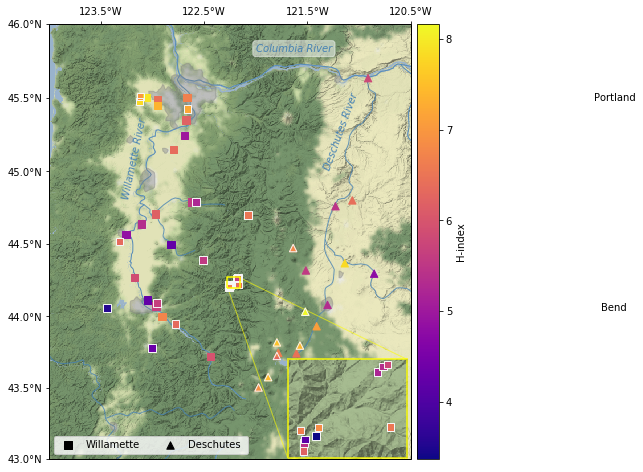

In [23]:
# ----------------------------------------------------------------------------
# --------------- FIGURES ----------------------------------------------------
# ----------------------------------------------------------------------------

colors = sns.color_palette()
colors_dict={'geomorphic': colors[5], 'land-cover': colors[2], 'climatic': colors[0], 'development': colors[3]}

'''
Figure 1 - Alpha diversity (Shannon’s index [H]) of the streamwater microbiome in the 
Willamette (squares) and Deschutes (triangles) watersheds in Oregon, USA.  
Outlined symbols indicate small sub-catchments (i.e., those with less than median drainage area).  
Inset shows vicinity of H.J. Andrews Experimental Forest.  
'''

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import offset_copy
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from shapely.geometry.polygon import LinearRing
from matplotlib.patheffects import Stroke
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.patches import ConnectionPatch


fig=plt.figure(1, figsize=(11,8))

curCol = 'H_index ()'
X0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc['LONGITUDE (decimal degrees)'].values
Y0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc['LATITUDE (decimal degrees)'].values
Z0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc[curCol].values
X1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc['LONGITUDE (decimal degrees)'].values
Y1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc['LATITUDE (decimal degrees)'].values
Z1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc[curCol].values

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)
ax.set_extent([-124.0, -120.5, 43.0, 46.0])
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.NaturalEarthFeature
               ('physical', 'rivers_north_america', '10m'), facecolor='None', edgecolor='steelblue', alpha = 0.8)
ax.add_feature(cfeature.NaturalEarthFeature
               ('physical', 'rivers_lake_centerlines', '10m'), facecolor='None', edgecolor='steelblue', alpha = 0.8)
ax.add_feature(cfeature.NaturalEarthFeature
               ('cultural', 'urban_areas', '10m'), facecolor='grey', edgecolor='grey', alpha=0.4)

# Determine color and range
cmap = mpl.cm.plasma
zs = np.concatenate([Z0, Z1], axis=0)
min_, max_ = zs.min(), zs.max()

msize = 55 #scale by drainage area?
outline = 'whitesmoke'

# Plot two datasets on one scale
im1 = plt.scatter(X0, Y0, transform=ccrs.Geodetic(), marker = 's', c= Z0, cmap= cmap, 
                  label = 'Willamette', zorder = 10, s = msize)
plt.clim(min_, max_)
plt.scatter(X1,Y1,transform=ccrs.Geodetic(), c=Z1, marker='^', cmap = cmap, 
            label = 'Deschutes ', zorder =10, s = msize) 
plt.clim(min_, max_)

for i in range(len(X0)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].columns)[i]]=='sm':
        plt.scatter(X0[i],Y0[i],transform=ccrs.Geodetic(), edgecolors=outline, facecolors='none', 
                marker='s', zorder = 12, s = msize)
for i in range(len(X1)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].columns)[i]]=='sm':
        plt.scatter(X1[i],Y1[i],transform=ccrs.Geodetic(), edgecolors=outline, facecolors='none', 
                marker='^', zorder = 12, s = msize)

plt.plot(-122.6750, 45.5051, marker='', markerfacecolor='k', markersize=6,
            alpha=0.7, transform=ccrs.Geodetic(), zorder = 11)
plt.plot(-121.3153, 44.0582, marker='', markerfacecolor='k', markersize=8,
            alpha=0.7, transform=ccrs.Geodetic(), zorder = 11)

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)

text_transform = offset_copy(geodetic_transform, units='dots', x=+450)
ax.text(-122.6750, 45.5051, u'Portland',
            verticalalignment='center', horizontalalignment='right',
            transform=text_transform)

text_transform = offset_copy(geodetic_transform, units='dots', x=+300)
ax.text(-121.3153, 44.0582, u'Bend',
            verticalalignment='center', horizontalalignment='right',
            transform=text_transform)

text_transform = offset_copy(geodetic_transform, units='dots', x=0)
ax.text(-123.3, 44.8, u'Willamette River', va='bottom', ha='left', style='italic', 
        rotation = 78, color = 'steelblue', transform=text_transform)

text_transform = offset_copy(geodetic_transform, units='dots', x=0)
ax.text(-121.35, 45.0, u'Deschutes River', va='bottom', ha='left', style='italic', 
        rotation = 70, color = 'steelblue', transform=text_transform)

text_transform = offset_copy(geodetic_transform, units='dots', x=0)
ax.text(-122.0, 45.8, u'Columbia River', va='bottom', ha='left', style='italic', 
        rotation = 0, color = 'steelblue', transform=text_transform, 
        bbox=dict(facecolor='white', edgecolor = 'white', alpha=0.5, boxstyle='round'))

leg = plt.legend(loc='lower left', ncol=2)
for marker in leg.legendHandles:
    marker.set_color('black')
    
fig.colorbar(im1, pad=0.01).set_label('H-index')

# Add HJ Andrews inset
inset_size = 0.33

ax3 = plt.axes([0.3, 0.3, 0.05, 0.05], projection=stamen_terrain.crs)
ins_extent = [-122.275, -122.15, 44.196, 44.27]
lonmin, lonmax, latmin, latmax = ins_extent
ax3.set_extent(ins_extent)
effect = Stroke(linewidth=2, foreground='yellow', alpha=0.7)
ax3.outline_patch.set_path_effects([effect])
ax3.add_image(stamen_terrain, 11)

ip = InsetPosition(ax, [0.66, -0.05, inset_size, inset_size])
ax3.set_axes_locator(ip)

ax3.scatter(X0, Y0, transform=ccrs.Geodetic(), marker = 's', c= Z0, cmap= cmap, edgecolors=outline, 
            label = 'Willamette', zorder = 10, s = msize)

nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='yellow', linewidth=1.5, zorder = 15)

#Connect point xyA in coordsA with point xyB in coordsB
xy1=(0.530, 0.415)
xy2=(1.0,1.0)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA = "axes fraction", axesA=ax, axesB=ax3,
                      arrowstyle="-", zorder=1, color='yellow', alpha=0.6)
ax.add_artist(con)

xy3=(0.495, 0.39)
xy4=(0,0.0)
con2 = ConnectionPatch(xyA=xy3, xyB=xy4, coordsA = "axes fraction", axesA=ax, axesB=ax3,
                      arrowstyle="-", zorder=1, color='yellow', alpha=0.6)
ax.add_artist(con2)

ax.set_xticks([-123.5, -122.5, -121.5, -120.5], crs=ccrs.PlateCarree())
ax.set_yticks([43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.1f')
lat_formatter = LatitudeFormatter(number_format='.1f')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.tick_top() 

plt.savefig('FIGS/FIG1.jpg', dpi=600)

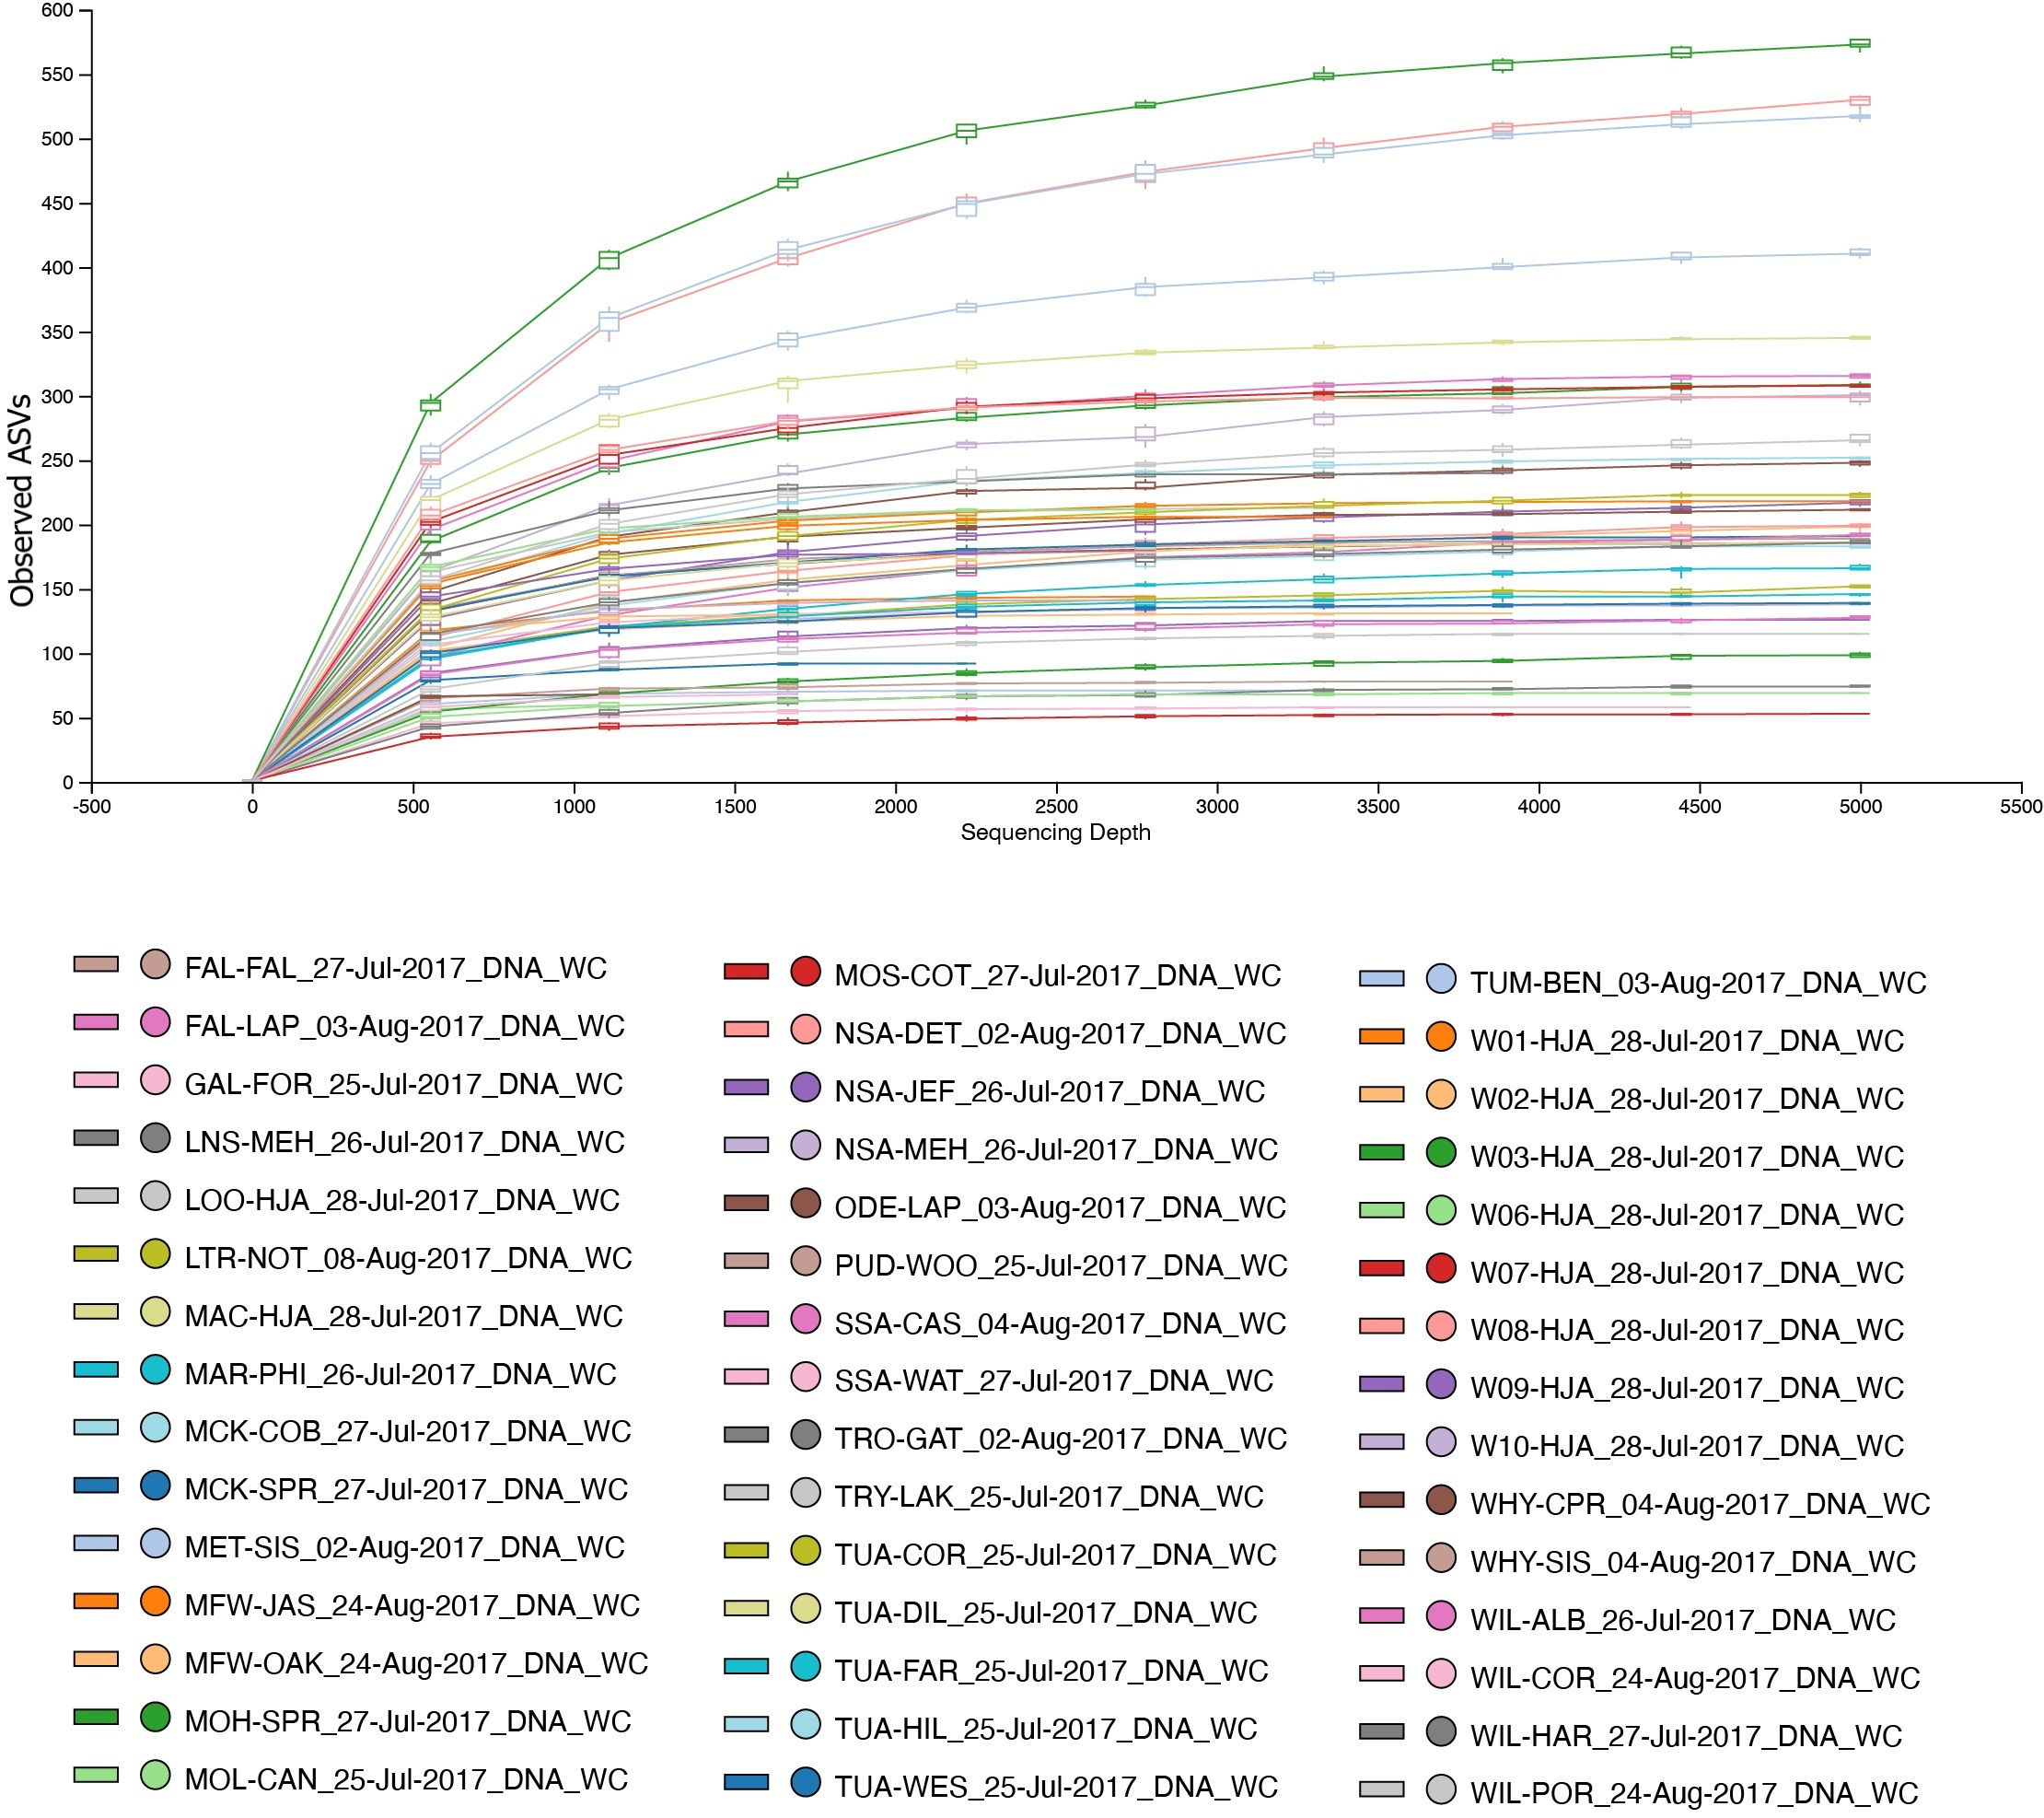

In [24]:
'''
Figure S1: Amplified sequence variant (ASV) rarefaction curves 
for each sample in the Willamette and Deschutes watersheds, Oregon, USA.
'''
from IPython.display import Image, display

figs1 = 'FIGS/FIG_S1.jpg'
display(Image(filename=figs1))

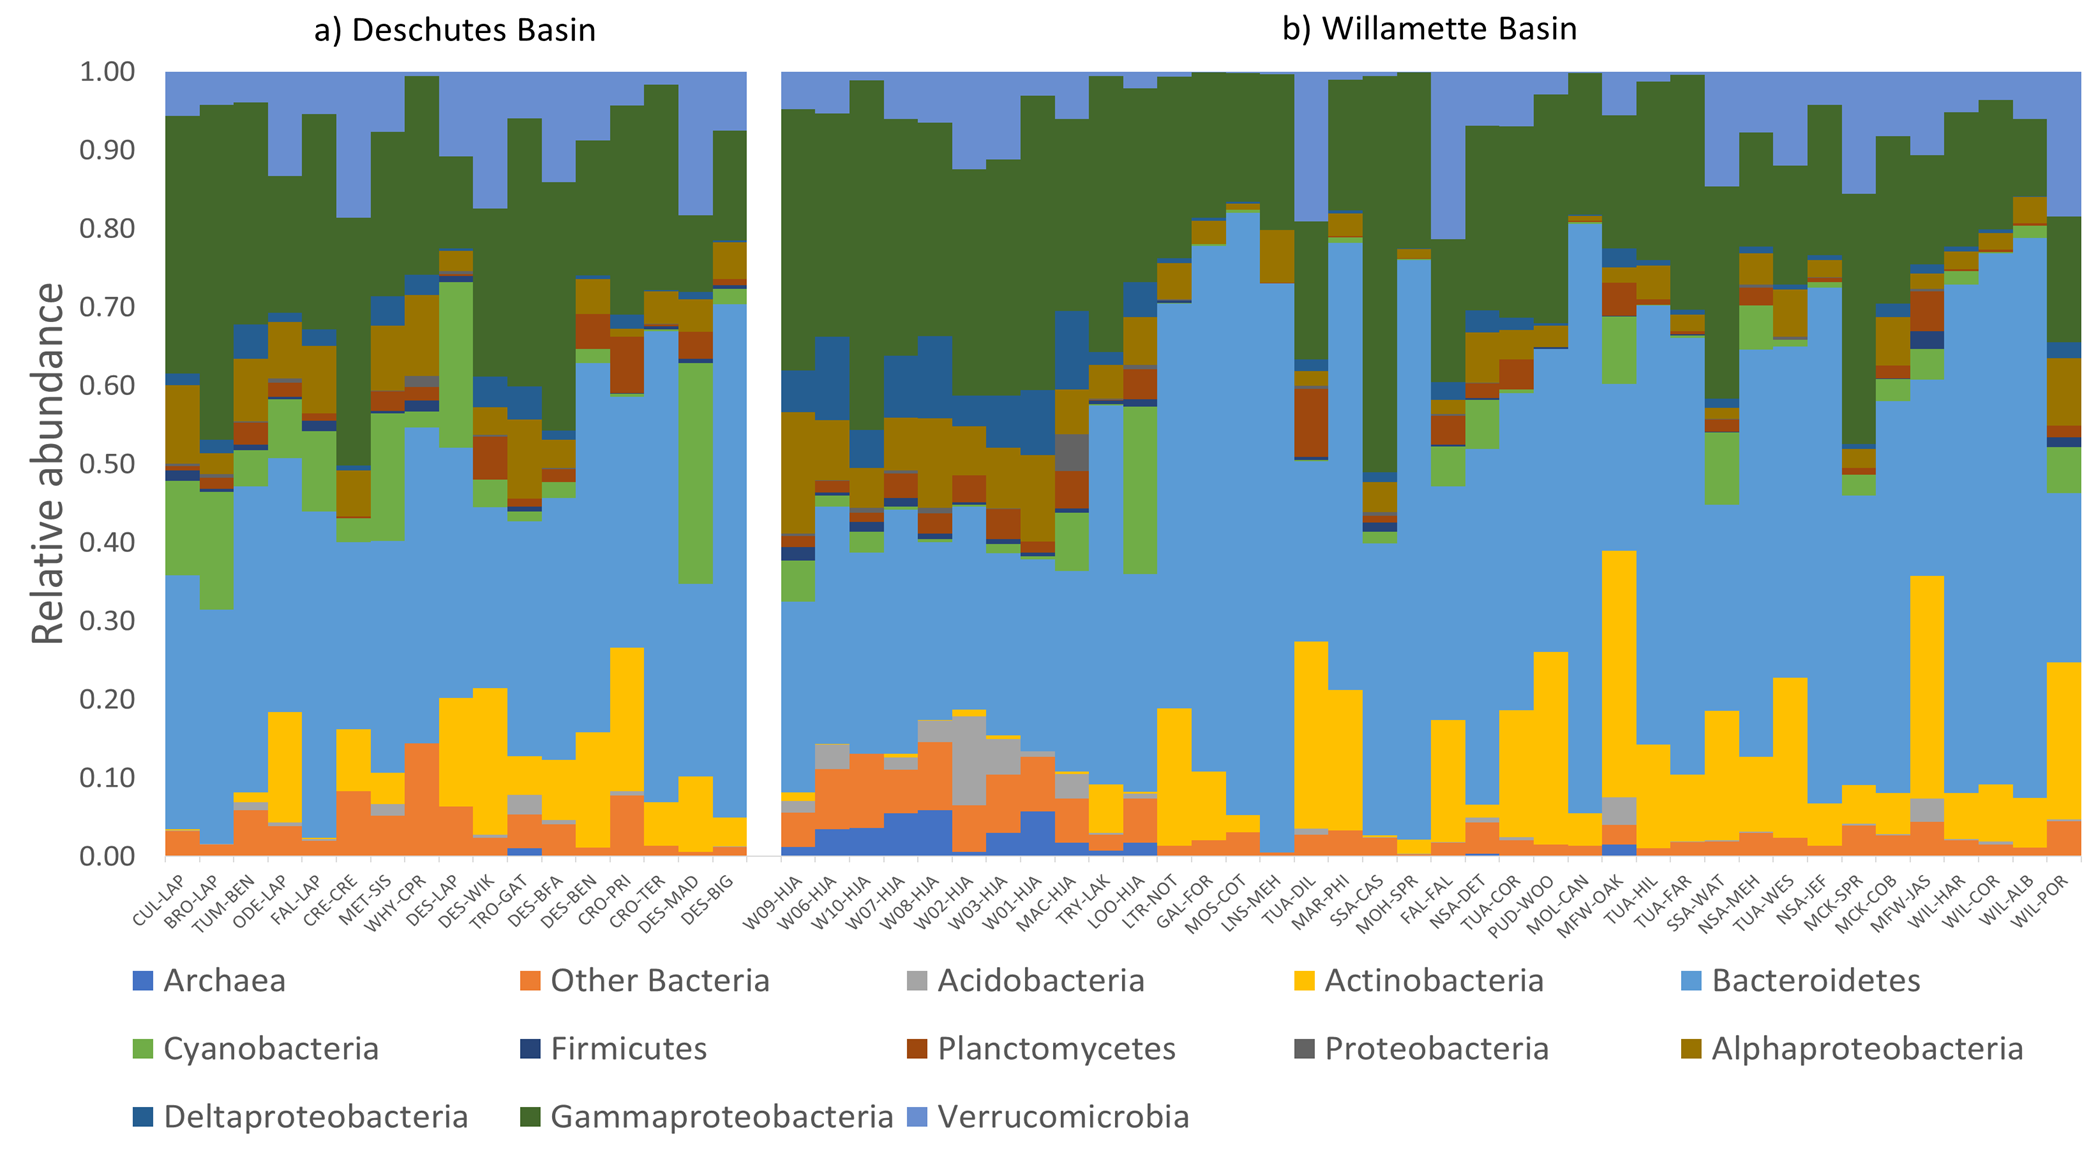

In [25]:
'''
Figure 2. Phylogenetic biodiversity (relative abundance of unique amplified sequences variants [ASVs]) of 
tributary and main-stem streamwater microbial DNA samples throughout the 
a) Deschutes and b) Willamette watersheds in Oregon, USA. 
Samples for each watershed are presented in order of increasing sub-catchment drainage area (Table S1).
'''

fig2 = 'FIGS/FIG2.png'
display(Image(filename=fig2))

-2.8249651512967165e-05 5.85417912878842 -0.031560669615152755 0.8507977301809417 0.00014910741203065037
0.00020384058067062332 6.275288764895572 0.2651906041007423 0.303624342613254 0.00019136046388742623
3.891307142975387e-05 5.989263165685053 0.042908342336885376 0.7557618502527566 0.00012445595327650934


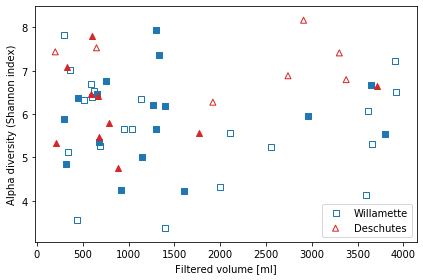

In [26]:
'''
Figure S2: Alpha diversity (Shannon index) of microbial DNA vs. 
filtered volume of streamwater collected from small (unfilled symbols) 
and large (filled symbols) sub-catchments throughout the 
Willamette (squares) and Deschutes (triangles) watersheds in Oregon, USA. 
'''

# Read in Filtered volumes
vols = pd.read_table(targetFolder+'URycki_metadata_vol.csv', sep=',', header=0, skiprows=0).set_index('site id')
vols_df = vols.VolA
vols_df.index = 'S17_' + vols_df.index
    
fig=plt.figure(3)

Y0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc[curCol]
X0 = vols_df.loc[vols_df.index.isin(Y0.index)]
Y1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc[curCol]
X1 = vols_df.loc[vols_df.index.isin(Y1.index)]

# Plot two datasets 
for i in range(len(X0)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].columns)[i]]=='sm':
        plt.scatter(X0[i],Y0[i],color = colors[0], facecolors='none', marker='s')
    else: 
        plt.scatter(X0[i],Y0[i], facecolors= colors[0], marker='s')
for i in range(len(X1)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].columns)[i]]=='sm':
        plt.scatter(X1[i],Y1[i],color = colors[3], facecolors='none', marker='^')
    else: 
        plt.scatter(X1[i],Y1[i],facecolors= colors[3], marker='^')
        
slope_w, intercept_w, r_value_w, p_value_w, std_err_w = stats.linregress(list(X0), list(Y0))
slope_d, intercept_d, r_value_d, p_value_d, std_err_d = stats.linregress(list(X1), list(Y1))
slope, intercept, r_value, p_value, std_err = stats.linregress(list(X1) + list(X0), list(Y1) + list(Y0))
print(slope_w, intercept_w, r_value_w, p_value_w, std_err_w)
print(slope_d, intercept_d, r_value_d, p_value_d, std_err_d) 
print (slope, intercept, r_value, p_value, std_err)

plt.scatter([],[],color = colors[0], facecolors='none', marker='s', label = 'Willamette')
plt.scatter([],[],color = colors[3], facecolors='none', marker='^', label = 'Deschutes')
plt.xlabel('Filtered volume [ml]')
plt.ylabel('Alpha diversity (Shannon index)')
plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig('FIGS/FIGS2.jpg', dpi=600)

1.0709741045771428 -41.9327401193303 0.5490317838025347 0.00035763655581419967 0.2717273569413481
-0.7141033359081865 38.10856630434218 -0.40750076135788826 0.10446711869765248 0.4131951596676532


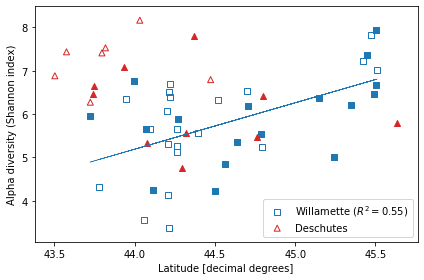

In [27]:
'''
Figure 3 - Alpha diversity (Shannon index) vs. latitudinal coordinate of streamwater microbial DNA samples 
collected from small (unfilled symbols) and large (filled symbols) sub-catchments throughout the 
Willamette (squares) and Deschutes (triangles) watersheds in Oregon, USA.
'''

fig=plt.figure(3)

X0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc['LATITUDE (decimal degrees)'].values
Y0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc[curCol].values
X1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc['LATITUDE (decimal degrees)'].values
Y1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc[curCol].values

# Plot two datasets 
for i in range(len(X0)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].columns)[i]]=='sm':
        plt.scatter(X0[i],Y0[i],color = colors[0], facecolors='none', marker='s')
    else: 
        plt.scatter(X0[i],Y0[i], facecolors= colors[0], marker='s')
for i in range(len(X1)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].columns)[i]]=='sm':
        plt.scatter(X1[i],Y1[i],color = colors[3], facecolors='none', marker='^')
    else: 
        plt.scatter(X1[i],Y1[i],facecolors= colors[3], marker='^')
        
slope_w, intercept_w, r_value_w, p_value_w, std_err_w = stats.linregress(list(X0), list(Y0))
slope_d, intercept_d, r_value_d, p_value_d, std_err_d = stats.linregress(list(X1), list(Y1))
plt.plot(X0, slope_w*X0+intercept_w, color = colors[0], linewidth = 0.5)

plt.scatter([],[],color = colors[0], facecolors='none', marker='s', label = 'Willamette ($\it{R^2={%.2f}}$)' %r_value_w)
plt.scatter([],[],color = colors[3], facecolors='none', marker='^', label = 'Deschutes')
plt.xlabel('Latitude [decimal degrees]')
plt.ylabel('Alpha diversity (Shannon index)')

plt.legend(loc='lower right')
plt.tight_layout()
print(slope_w, intercept_w, r_value_w, p_value_w, std_err_w)
print(slope_d, intercept_d, r_value_d, p_value_d, std_err_d)
plt.savefig('FIGS/FIG3.jpg', dpi=600)


8.87139697745982e-06 5.790299894529847 0.043325904837049595 0.7961921912137178 3.4094562668301236e-05
-4.5510011151088655e-05 6.798200936178221 -0.3849250941811362 0.12708609365083526 2.817489033716326e-05


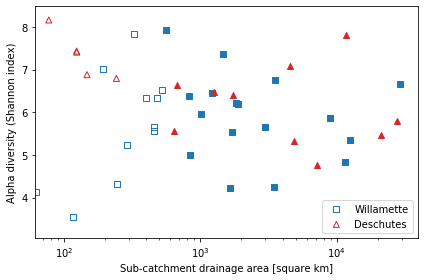

In [28]:
# Figure S2: Alpha diversity (Shannon index) of microbial DNA collected from streamwater 
# vs. sub-catchment drainage area in small (unfilled symbols) and large (filled symbols) sub-catchments throughout the 
# Willamette (squares) and Deschutes (triangles) watersheds in Oregon, USA.

fig=plt.figure(3)

X0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc['DRNAREA (square km*)'].values
Y0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc[curCol].values

X1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc['DRNAREA (square km*)'].values
Y1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc[curCol].values

# Plot two datasets 
for i in range(len(X0)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].columns)[i]]=='sm':
        plt.scatter(X0[i],Y0[i],color = colors[0], facecolors='none', marker='s')
    else: 
        plt.scatter(X0[i],Y0[i], facecolors=colors[0], marker='s')
for i in range(len(X1)):
    if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].columns)[i]]=='sm':
        plt.scatter(X1[i],Y1[i],color = colors[3], facecolors='none', marker='^')
    else: 
        plt.scatter(X1[i],Y1[i],facecolors=colors[3], marker='^')
        
slope_w, intercept_w, r_value_w, p_value_w, std_err_w = stats.linregress(list(X0), list(Y0))
slope_d, intercept_d, r_value_d, p_value_d, std_err_d = stats.linregress(list(X1), list(Y1))
print(slope_w, intercept_w, r_value_w, p_value_w, std_err_w)
print(slope_d, intercept_d, r_value_d, p_value_d, std_err_d)

plt.scatter([],[],color = colors[0], facecolors='none', marker='s', label = 'Willamette')
plt.scatter([],[],color = colors[3], facecolors='none', marker='^', label = 'Deschutes')
plt.xlabel('Sub-catchment drainage area [square km]')
plt.xscale('log')
plt.ylabel('Alpha diversity (Shannon index)')

plt.legend()
plt.tight_layout()
plt.savefig('FIGS/FIGS3.jpg', dpi=600)

Ttest_indResult(statistic=2.495614753661144, pvalue=0.015721649579322355)
Ttest_indResult(statistic=0.3043897783157237, pvalue=0.7620229460244393)
Wil mean H = 5.81, SD = 1.08
Des mean H = 6.58, SD = 0.93
Sm mean H = 6.09, SD = 1.22
Lg mean H = 6.00, SD = 0.95


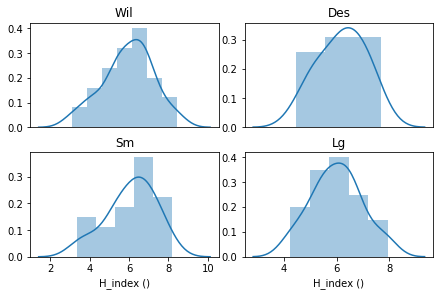

In [29]:
#Compare alpha diversity among catchments

plt.subplot(221)
ax1 = sns.distplot(cur_df_ss_W.T['H_index ()'])
ax1.set_title('Wil')
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(222)
ax2 = sns.distplot(cur_df_ss_D.T['H_index ()'])
ax2.set_title('Des')
x_axis = ax2.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(223)
ax3=sns.distplot(cur_df_ss_sm.T['H_index ()'])
ax3.set_title('Sm')

plt.subplot(224)
ax4=sns.distplot(cur_df_ss_lg.T['H_index ()'])
ax4.set_title('Lg')
plt.tight_layout(pad =0.3)

print(stats.ttest_ind(cur_df_ss_D.T['H_index ()'], cur_df_ss_W.T['H_index ()']))

print(stats.ttest_ind(cur_df_ss_sm.T['H_index ()'], cur_df_ss_lg.T['H_index ()']))

print('Wil mean H = %.2f, SD = %.2f' %(np.mean(cur_df_ss_W.T['H_index ()']), (np.std(cur_df_ss_W.T['H_index ()']))))

print('Des mean H = %.2f, SD = %.2f' %(np.mean(cur_df_ss_D.T['H_index ()']),(np.std(cur_df_ss_D.T['H_index ()']))))

print('Sm mean H = %.2f, SD = %.2f' %(np.mean(cur_df_ss_sm.T['H_index ()']),(np.std(cur_df_ss_sm.T['H_index ()']))))

print('Lg mean H = %.2f, SD = %.2f' %(np.mean(cur_df_ss_lg.T['H_index ()']),(np.std(cur_df_ss_lg.T['H_index ()']))))


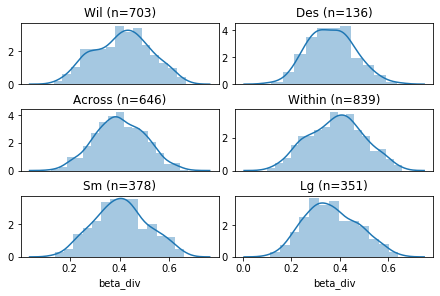

Wil vs Des beta diversity:
WW=0.397+-0.116
DD=0.384+-0.084
 MannwhitneyuResult(statistic=43768.0, pvalue=0.05938986547931946)


Across vs Within beta diversity:
Across=0.408+-0.096
Within=0.395+-0.112
 MannwhitneyuResult(statistic=253091.0, pvalue=0.014422487409761315)


Small vs Large beta diversity:
sm=0.407+-0.107
lg=0.365+-0.108
 MannwhitneyuResult(statistic=51954.0, pvalue=2.0614574874253143e-07)
1485


In [30]:
#Compare beta diversity among catchments
from itertools import combinations

site_dict = { cur_df_otus_A.columns[i] : i for i in range(0, len(cur_df_otus_A.columns) ) }
lats_dict = pd.Series(cur_df_ss_A.T['LATITUDE (decimal degrees)'].values,index=cur_df_ss_A.T.Site).to_dict()
lons_dict = pd.Series(cur_df_ss_A.T['LONGITUDE (decimal degrees)'].values,index=cur_df_ss_A.T.Site).to_dict()
dist_table = pd.DataFrame(combinations(cur_df_otus_A.columns, 2), columns = ['site1', 'site2'])
dist_table['lat1'] = dist_table['site1'].str.strip().str[-7:].map(lats_dict)
dist_table['lon1'] = dist_table['site1'].str.strip().str[-7:].map(lons_dict)
dist_table['lat2'] = dist_table['site2'].str.strip().str[-7:].map(lats_dict)
dist_table['lon2'] = dist_table['site2'].str.strip().str[-7:].map(lons_dict)


dist_table['beta_div'] = np.nan
bds = list()
for index, row in dist_table.iterrows():
    bds.append(cur_df_bd_A[site_dict[row.site1], site_dict[row.site2]])
dist_table = dist_table.assign(beta_div=bds)

dist_table['basin1']=dist_table.site1.map(basin_dict)
dist_table['basin2']=dist_table.site2.map(basin_dict)
dist_table['size1']=dist_table.site1.map(size_dict)
dist_table['size2']=dist_table.site2.map(size_dict)

bd_all_mean = dist_table['beta_div'].mean()

bd_wd = dist_table[(dist_table['basin1'] != dist_table['basin2'])]['beta_div']
bd_wd_mean = bd_wd.mean()
bd_wd_sd = bd_wd.std()

bd_w = dist_table[(dist_table['basin1'] == 'W') & (dist_table['basin2'] == 'W')]['beta_div']
bd_w_mean = bd_w.mean()
bd_w_sd = bd_w.std()

bd_d = dist_table[(dist_table['basin1'] == 'D') & (dist_table['basin2'] == 'D')]['beta_div']
bd_d_mean= bd_d.mean()
bd_d_sd = bd_d.std()

bd_within = bd_w.append(bd_d, ignore_index=True)
bd_within_mean = bd_within.mean()
bd_within_sd = bd_within.std()

bd_sm = dist_table[(dist_table['size1'] == 'sm') & (dist_table['size2'] == 'sm')]['beta_div']
bd_sm_mean = bd_sm.mean()
bd_sm_sd = bd_sm.std()

bd_lg = dist_table[(dist_table['size1'] == 'lg') & (dist_table['size2'] == 'lg')]['beta_div']
bd_lg_mean = bd_lg.mean()
bd_lg_sd = bd_lg.std()

#Visualize beta diversity distributions
plt.figure()
plt.subplot(321)
ax1 = sns.distplot(bd_w)
ax1.set_title('Wil (n=%d)' %len(bd_w))
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(322)
ax2 = sns.distplot(bd_d)
ax2.set_title('Des (n=%d)' %len(bd_d))
x_axis = ax2.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(323)
ax3=sns.distplot(bd_wd)
ax3.set_title('Across (n=%d)' %len(bd_wd))
x_axis = ax3.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(324)
ax4=sns.distplot(bd_within)
ax4.set_title('Within (n=%d)' %len(bd_within))
x_axis = ax4.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(325)
ax3=sns.distplot(bd_sm)
ax3.set_title('Sm (n=%d)' %len(bd_sm))

plt.subplot(326)
ax3=sns.distplot(bd_lg)
ax3.set_title('Lg (n=%d)' %len(bd_lg))

plt.tight_layout(pad =0.3)
plt.show()

print('Wil vs Des beta diversity:\nWW=%.3f+-%.3f\nDD=%.3f+-%.3f\n' %(bd_w_mean, bd_w_sd, bd_d_mean, bd_d_sd), stats.mannwhitneyu(bd_w, bd_d))
print('\n\nAcross vs Within beta diversity:\nAcross=%.3f+-%.3f\nWithin=%.3f+-%.3f\n' %(bd_wd_mean, bd_wd_sd, bd_within_mean, bd_within_sd), stats.mannwhitneyu(bd_wd, bd_within))
print('\n\nSmall vs Large beta diversity:\nsm=%.3f+-%.3f\nlg=%.3f+-%.3f\n' %(bd_sm_mean, bd_sm_sd, bd_lg_mean, bd_lg_sd), stats.mannwhitneyu(bd_sm, bd_lg))

print(len(dist_table['beta_div']))

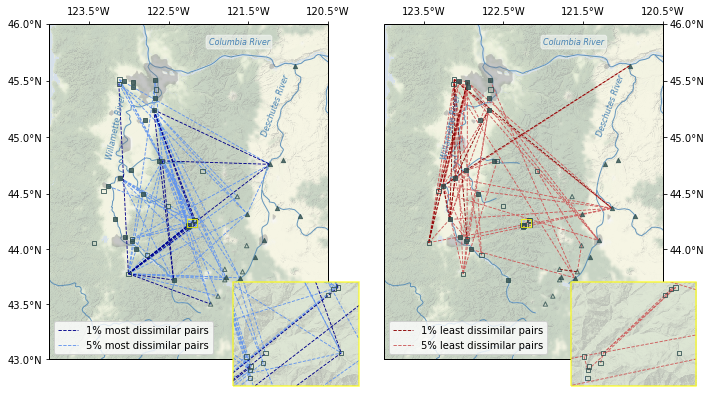

In [31]:
'''
Figure 4. Map of the 1% (dark lines) and 5% (light lines) most (left) and least (right) 
dissimilar microbial communities throughout the 
Willamette and Deschutes watersheds in Oregon, USA. 
Large (filled symbols) and small (unfilled symbols) sub-catchments are those with 
more than or less than median drainage area, respectively.  
Inset shows vicinity of H.J. Andrews Experimental Forest. 
'''

top_01 = dist_table.nlargest(int((0.01*len(dist_table))), 'beta_div')
top_05 = dist_table.nlargest(int((0.05*len(dist_table))), 'beta_div').drop(index = top_01.index)
bot_01 = dist_table.nsmallest(int((0.01*len(dist_table))), 'beta_div')
bot_05 = dist_table.nsmallest(int((0.05*len(dist_table))), 'beta_div').drop(index = bot_01.index)

fig=plt.figure(4, figsize=(11,8))

X0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc['LONGITUDE (decimal degrees)'].values
Y0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc['LATITUDE (decimal degrees)'].values
Z0 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].loc[curCol].values
X1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc['LONGITUDE (decimal degrees)'].values
Y1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc['LATITUDE (decimal degrees)'].values
Z1 = cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].loc[curCol].values

# Most similar
ax1 = fig.add_subplot(1, 2, 1, projection=stamen_terrain.crs)
extent = [-124.0, -120.5, 43.0, 46.0]
ax1.set_extent(extent)
ax1.add_image(stamen_terrain, 8, alpha = 0.4)
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', '10m'), facecolor='None', edgecolor='steelblue', alpha = 0.8)
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m'), facecolor='None', edgecolor='steelblue', alpha = 0.8)
ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'urban_areas', '10m'), facecolor='grey', alpha=0.4)

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.45

# Add HJAndrews inset
ax3 = plt.axes([0, 0, 1, 1], projection=stamen_terrain.crs)
ins_extent = [-122.275, -122.15, 44.196, 44.27]
lonmin, lonmax, latmin, latmax = ins_extent
ax3.set_extent(ins_extent)
effect = Stroke(linewidth=1.5, foreground='yellow', alpha=0.7)
ax3.outline_patch.set_path_effects([effect])
ax3.add_image(stamen_terrain, 12, alpha = 0.4)

ip = InsetPosition(ax1, [0.66, -0.15, inset_size, inset_size])
ax3.set_axes_locator(ip)

nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='yellow', linewidth=0.75, zorder = 5) 

for index, row in top_05.iterrows():
    ax1.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='cornflowerblue', ls = 'dashed', linewidth=0.9)
    ax3.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='cornflowerblue', ls = 'dashed', linewidth=0.9)

for index, row in top_01.iterrows():
    ax1.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='darkblue', ls = 'dashed', linewidth=0.9)
    ax3.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='darkblue', ls = 'dashed', linewidth=0.9)

# Add legend
legend_elements = [Line2D([0], [0], color='darkblue', lw=0.9, ls = 'dashed', label='1% most dissimilar pairs'),
                   Line2D([0], [0], color='cornflowerblue', lw=0.9, ls = 'dashed', label='5% most dissimilar pairs')]
ax1.legend(handles=legend_elements, loc='lower left')

# Most different
ax2 = fig.add_subplot(1, 2, 2, projection=stamen_terrain.crs)
ax2.set_extent([-124.0, -120.5, 43.0, 46.0], )
ax2.add_image(stamen_terrain, 8, alpha = 0.4)
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_north_america', '10m'), facecolor='None', edgecolor='steelblue', alpha = 0.8)
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m'), facecolor='None', edgecolor='steelblue', alpha = 0.8)
ax2.add_feature(cfeature.NaturalEarthFeature('cultural', 'urban_areas', '10m'), facecolor='grey', alpha=0.4)

# Add HJAndrews inset
ax4 = plt.axes([1, 1, 1, 1], projection=stamen_terrain.crs)
ax4.set_extent(ins_extent)
ax4.outline_patch.set_path_effects([effect])
ax4.add_image(stamen_terrain, 12, alpha = 0.4)
ip2 = InsetPosition(ax1, [1.87, -0.15, inset_size, inset_size])
ax4.set_axes_locator(ip2)

ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='yellow', linewidth=0.75, zorder = 5) 

# Plot data
for index, row in bot_05.iterrows():
    ax2.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='indianred', ls = 'dashed', linewidth=0.9)
    ax4.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='indianred', ls = 'dashed', linewidth=0.9)
for index, row in bot_01.iterrows():
    ax2.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='darkred', ls = 'dashed', linewidth=0.9)
    ax4.plot([row.lon1, row.lon2], [row.lat1, row.lat2], transform=ccrs.Geodetic(), 
             color='darkred', ls = 'dashed', linewidth=0.9)

for ax in [ax1, ax2, ax3, ax4]:
    for i in range(len(X0)):
        if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 10001.0].columns)[i]]=='sm':
            ax.scatter(X0[i],Y0[i],transform=ccrs.Geodetic(), color = 'darkslategrey', facecolors='none', 
                    marker='s', s= 18, zorder = 3, alpha = 0.8)
        else: 
            ax.scatter(X0[i],Y0[i],transform=ccrs.Geodetic(), facecolors='darkslategrey', 
                    marker='s', s= 18, zorder = 3, alpha = 0.8)
    for i in range(len(X1)):
        if size_dict[(cur_df_ss_A.iloc[:,cur_df_ss_A.loc['ORREG2 (dimensionless)'].values == 363.0].columns)[i]]=='sm':
            ax.scatter(X1[i],Y1[i],transform=ccrs.Geodetic(), color = 'darkslategrey', facecolors='none', 
                    marker='^', s= 18, zorder = 3, alpha = 0.8)
        else: 
            ax.scatter(X1[i],Y1[i],transform=ccrs.Geodetic(), facecolors='darkslategrey', 
                    marker='^', s= 18, zorder = 3, alpha = 0.8)
    
for ax in [ax1, ax2]:
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
    textsize = 8
    text_transform = offset_copy(geodetic_transform, units='dots', x=0)
    ax.text(-123.3, 44.8, u'Willamette River', va='bottom', ha='left', style='italic', 
        rotation = 78, color = 'steelblue', transform=text_transform, fontsize = textsize)

    text_transform = offset_copy(geodetic_transform, units='dots', x=0)
    ax.text(-121.35, 45.0, u'Deschutes River', va='bottom', ha='left', style='italic', 
        rotation = 70, color = 'steelblue', transform=text_transform, fontsize = textsize)

    text_transform = offset_copy(geodetic_transform, units='dots', x=0)
    ax.text(-122.0, 45.8, u'Columbia River', va='bottom', ha='left', style='italic', 
        rotation = 0, color = 'steelblue', transform=text_transform, fontsize = textsize,
        bbox=dict(facecolor='white', edgecolor = 'white', alpha=0.5, boxstyle='round'))    
    
    ax.set_xticks([-123.5, -122.5, -121.5, -120.5], crs=ccrs.PlateCarree())
    if ax==ax1: ax.set_yticks([43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0], crs=ccrs.PlateCarree())
    else: ax.set_yticks([44.0, 44.5, 45.0, 45.5, 46.0], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.1f')
    lat_formatter = LatitudeFormatter(number_format='.1f')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.tick_top() 
    if ax == ax2: ax.yaxis.tick_right()
    
legend_elements = [Line2D([0], [0], color='darkred', linewidth=0.9, ls = 'dashed', label='1% least dissimilar pairs'),
                   Line2D([0], [0], color='indianred', linewidth=0.9, ls = 'dashed', label='5% least dissimilar pairs')]
ax2.legend(handles=legend_elements, loc='lower left')

plt.savefig('FIGS/FIG4.jpg', dpi=600)
#plt.show()

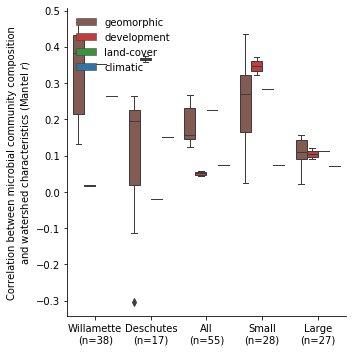

In [32]:
# Figure 5 - Mean correlation between microbial community composition (Mantel test statistic [r]) for 
# land-cover, geomorphic, and climatic related StreamStats basin characteristics by watershed and in 
# small and large sub-catchments across the Willamette and Deschutes watersheds, Oregon, USA. 

cols = ['Category', 'Mantel r']
frames = []
group_names = {'Wil': 'Willamette\n(n=38)', 'Des': 'Deschutes\n(n=17)', 'All': 'All\n(n=55)', 'Sm': 'Small\n(n=28)', 'Lg': 'Large\n(n=27)'}

for group in groups:
    frame = pd.DataFrame(index = table_1.index)
    frame['Category'] = table_1.Category
    frame['Mantel r'] = table_1_raw[group + ' Mantel']
    frame['group'] = group_names[group]
    frames.append(frame)

tb_1 = pd.concat(frames, axis=0)

import seaborn as sns

fig = sns.catplot(x="group", y="Mantel r", hue="Category", kind="box", data=tb_1, palette = colors_dict, legend=False, linewidth = 1);

plt.xlabel('')
plt.ylabel("Correlation between microbial community composition\nand watershed characteristics (Mantel ${\it r}$)")
plt.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('FIGS/FIG5_adjp.jpg', dpi = 600, transparent=True)


Wil-Des:
Overall: W = 18.0, p = 0.182
geomorphic: W = 3.0, p = 0.063
development: W = 1.0, p = 0.655
land-cover: W = 0.0, p = 0.317
climatic: W = 0.0, p = 0.317

Small-Large:
Overall: W = 30.0, p = 0.790
geomorphic: W = 13.0, p = 0.866
development: W = 0.0, p = 0.180
land-cover: W = 0.0, p = 0.317
climatic: W = 0.0, p = 0.317


/home/uryckid/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


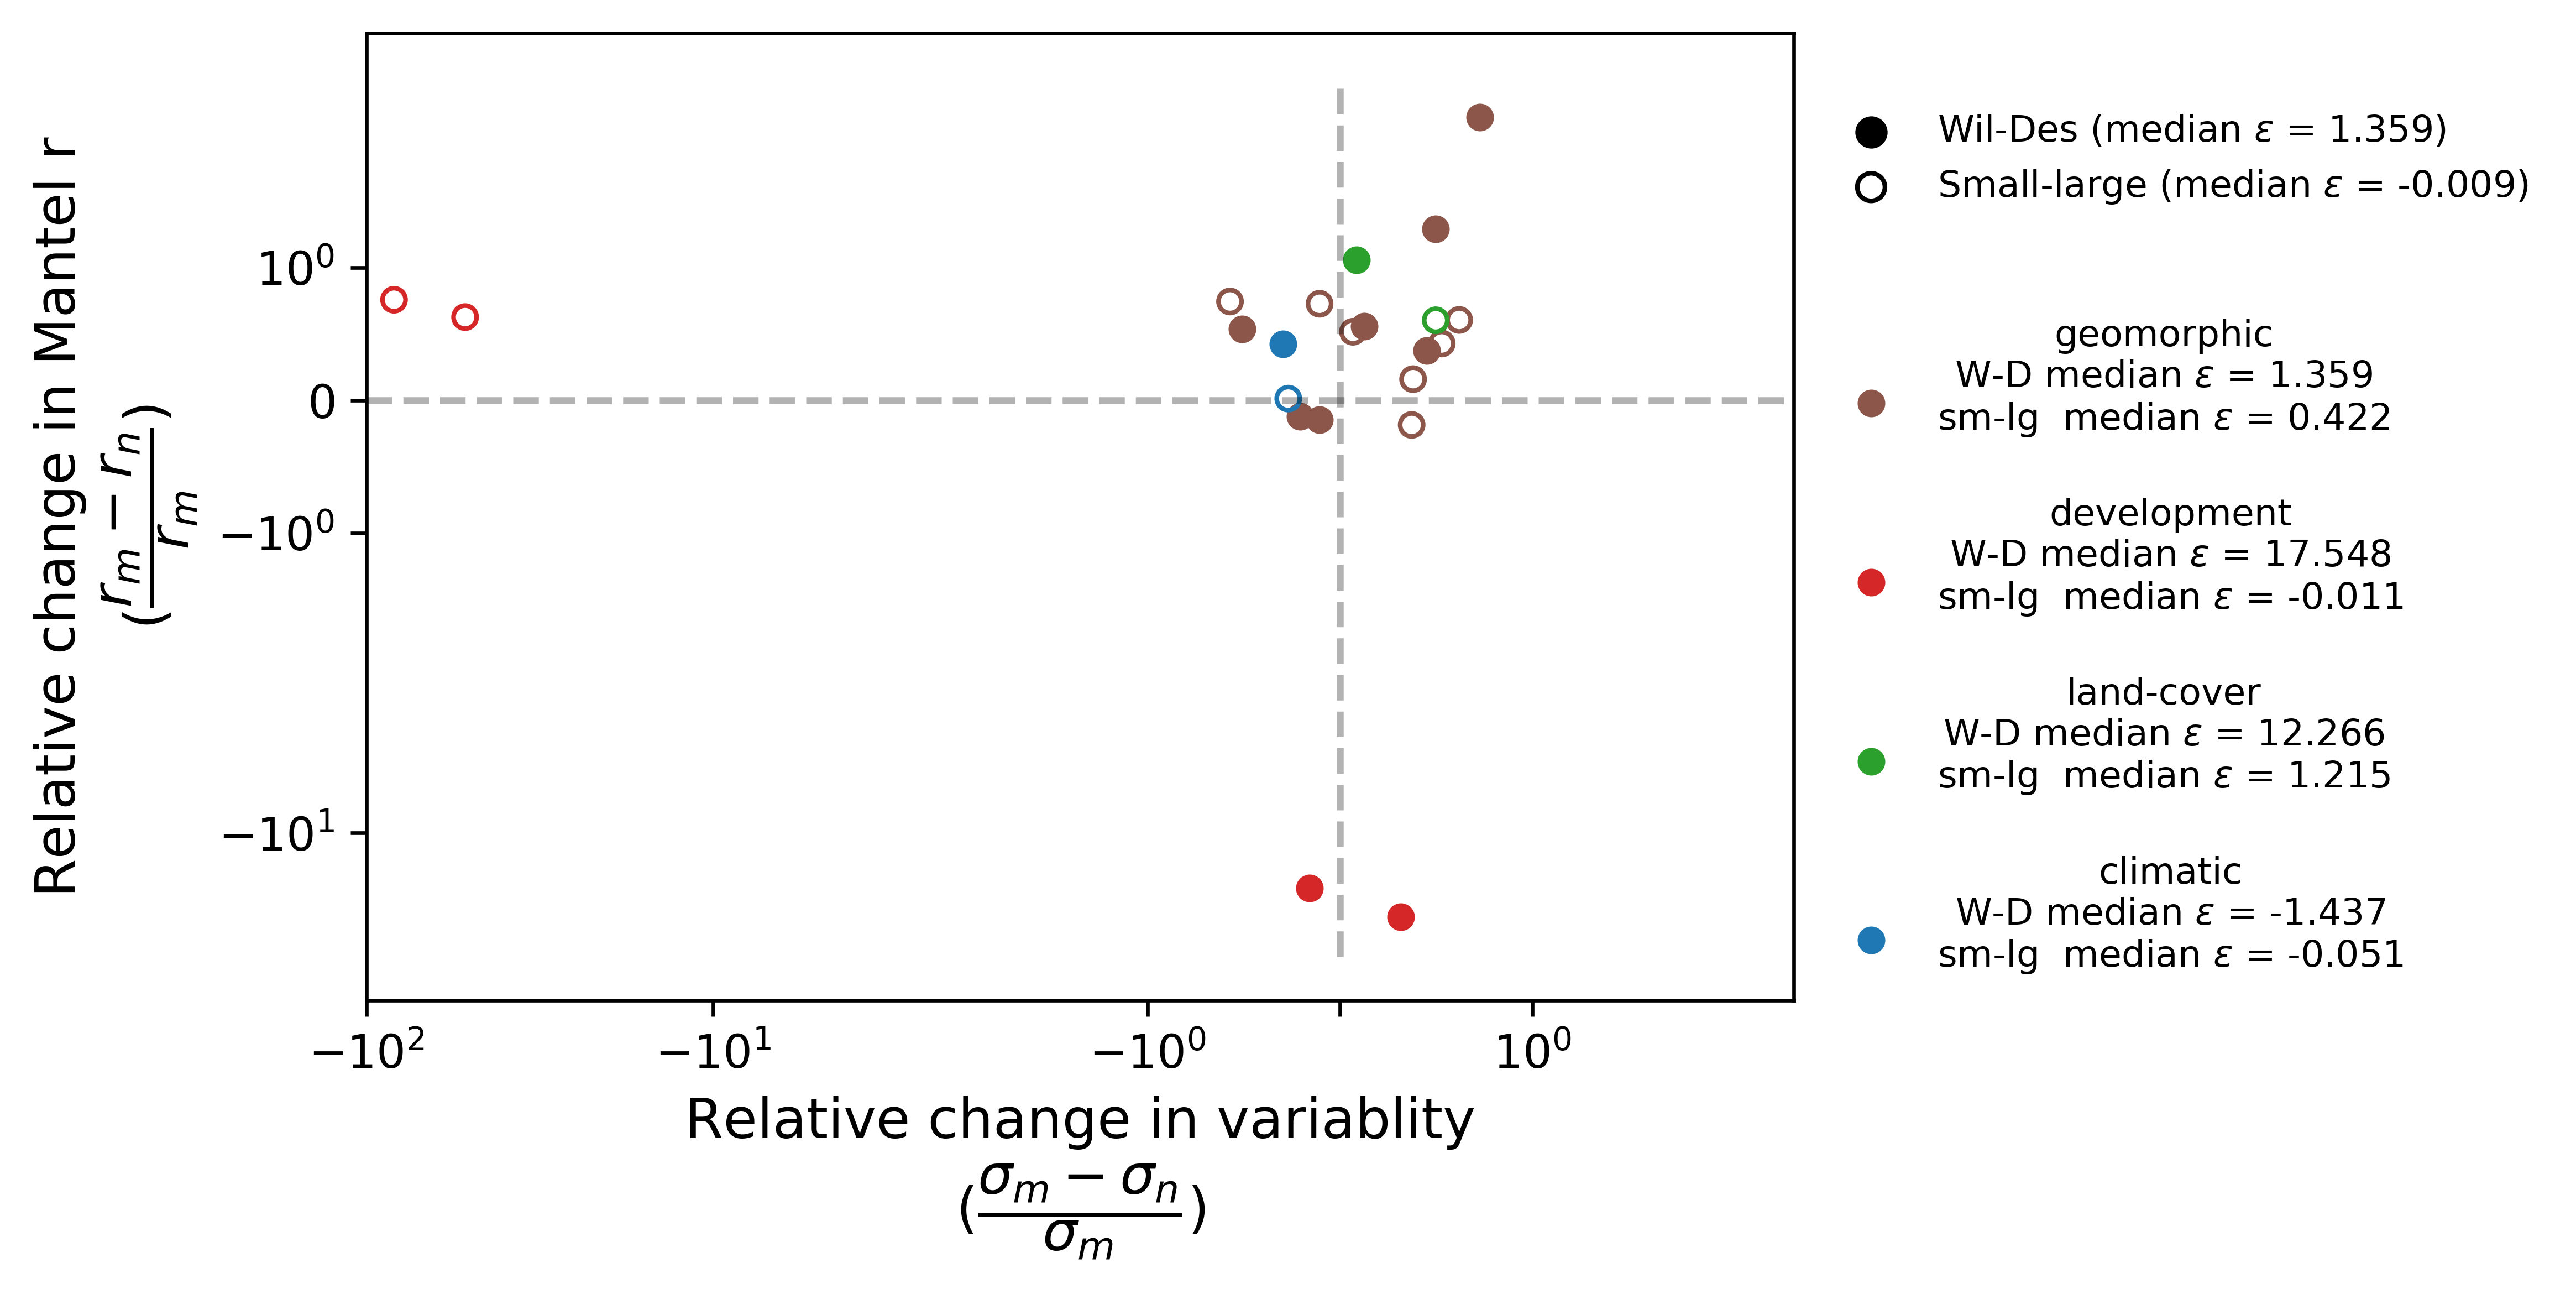

In [33]:
# Relative sensitivity of microbial community correlation (Mantel r) to variability of watershed characteristics 

table_diffs = pd.DataFrame(index = table_1_raw.index)

table_diffs['Category'] = table_1_raw.Category
table_diffs['rW'] = table_1_raw['Wil Mantel']
table_diffs['rD'] = table_1_raw['Des Mantel']
table_diffs['(rW-rD)'] = (table_1_raw['Wil Mantel'] - table_1_raw['Des Mantel'])
table_diffs['(rW-rD)/rW'] = (table_1_raw['Wil Mantel'] - table_1_raw['Des Mantel'])/table_1_raw['Wil Mantel']
table_diffs['(sdW-sdD)/sdW'] = (table_1_raw['Wil sd'] - table_1_raw['Des sd'])/table_1_raw['Wil sd']
table_diffs['WD_eps'] = table_diffs['(rW-rD)/rW']/table_diffs['(sdW-sdD)/sdW']

table_diffs['r_sm-r_lg'] = table_1_raw['Sm Mantel'] - table_1_raw['Lg Mantel']
table_diffs['(r_sm-r_lg)/r_sm'] =(table_1_raw['Sm Mantel'] - table_1_raw['Lg Mantel'])/table_1_raw['Sm Mantel']
table_diffs['(sd_sm-sd_lg)/sd_sm'] =(table_1_raw['Sm sd'] - table_1_raw['Lg sd'])/table_1_raw['Sm sd']
table_diffs['SL_eps'] = table_diffs['(r_sm-r_lg)/r_sm']/table_diffs['(sd_sm-sd_lg)/sd_sm']

plt.figure(8,  dpi=600)
ax = plt.subplot(111)

plt.scatter([], [], marker = 'o', color = 'k', 
            label= ("Wil-Des (median $\epsilon$ = %.3f)" %np.nanmedian(table_diffs['WD_eps'])))
plt.scatter([], [], marker ='o', edgecolors = 'k', facecolors = 'none', 
            label = ("Small-large (median $\epsilon$ = %.3f)" %np.nanmedian(table_diffs['SL_eps'])))
plt.scatter([], [], marker ='', edgecolors = 'k', facecolors = 'none', 
            label = '\n')

for cat in list(table_diffs.Category.unique()):
    x1 = table_diffs.loc[table_diffs.Category==cat]['(sdW-sdD)/sdW']
    y1 = table_diffs.loc[table_diffs.Category==cat]['(rW-rD)/rW']
    plt.scatter(x1, y1, s= 25, color = colors_dict[cat], marker = 'o',
                label = ('%s\nW-D median $\epsilon$ = %.3f\nsm-lg  median $\epsilon$ = %.3f\n' 
                         %(cat, table_diffs.groupby('Category').median(skipna=True)['WD_eps'][cat], 
                           table_diffs.groupby('Category').median(skipna=True)['SL_eps'][cat])))
    x2 = table_diffs.loc[table_diffs.Category==cat]['(sd_sm-sd_lg)/sd_sm']
    y2 = table_diffs.loc[table_diffs.Category==cat]['(r_sm-r_lg)/r_sm']
    plt.scatter(x2, y2, s= 25, edgecolors = colors_dict[cat], marker = 'o', facecolors = 'none')

plt.xscale('symlog')
plt.yscale('symlog')
ax.set_xlim(-10**2, 10**0.5)
xticks = ax.xaxis.get_major_ticks()
xticks[3].label1.set_visible(False)
yticks = ax.yaxis.get_major_ticks()

plt.ylabel('Relative change in Mantel r\n($\dfrac{r_m-r_n}{r_m}$)', fontsize = 12)
plt.xlabel('Relative change in variablity\n($\dfrac{\sigma_m-\sigma_n}{\sigma_m}$)', fontsize = 12)

xlow, xhigh, ylow, yhigh = plt.axis()
plt.hlines(y=0, xmin=xlow, xmax=xhigh, alpha = 0.3, ls = 'dashed')
plt.vlines(x=0, ymin=ylow, ymax=yhigh, alpha = 0.3, ls = 'dashed')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height * 0.6])

leg = ax.legend(loc='center left', bbox_to_anchor=(1.005, 0.45), frameon = False, fontsize =8)
for t in leg.texts:
    t.set_multialignment('center')
plt.tight_layout()

table_diffs = table_diffs.replace([np.inf, -np.inf], np.nan).dropna()

print('\nWil-Des:')
w1, p1 = stats.wilcoxon(table_diffs['WD_eps'])
print("Overall: W = %.1f, p = %.3f" %(w1, p1))
for cat in list(table_diffs.Category.unique()):
    w, p = stats.wilcoxon(table_diffs.loc[table_diffs.Category==cat]['WD_eps'])
    print('{}: W = %.1f, p = %.3f'.format(cat) %(w, p))
    
print('\nSmall-Large:')
w2, p2 = stats.wilcoxon(table_diffs['SL_eps'])
print('Overall: W = %.1f, p = %.3f' %(w2, p2))
for cat in list(table_diffs.Category.unique()):
    w, p = stats.wilcoxon(table_diffs.loc[table_diffs.Category==cat]['SL_eps'])
    print('{}: W = %.1f, p = %.3f'.format(cat) %(w, p))

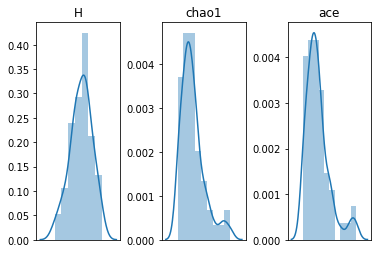

0.9126262626262629 3.059723933135657e-22
0.9048340548340551 2.6633537198041277e-21


In [34]:
# Compare alpha diversity metrics
cur_df_ss.loc['H_index ()']
alpha_df = pd.DataFrame()
alpha_df['H_ind'] = cur_df_ss.loc['H_index ()']
chao1 = []
ace = []
for s in alpha_df.index:
    #print(cur_df_otus[s])
    chao1.append(alpha.chao1(cur_df_otus[s].values))
    ace.append(alpha.ace(cur_df_otus[s].values.astype(int)))
alpha_df['chao1']=pd.Series(chao1, index = alpha_df.index)
alpha_df['ace'] = pd.Series(ace, index = alpha_df.index)
alpha_df.head()

# Examine distributions
plt.subplot(131)
ax1 = sns.distplot(alpha_df['H_ind'])
ax1.set_title('H')
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(132)
ax2 = sns.distplot(alpha_df['chao1'])
ax2.set_title('chao1')
x_axis = ax2.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplot(133)
ax3=sns.distplot((alpha_df['ace']))
ax3.set_title('ace')
x_axis = ax3.axes.get_xaxis()
x_axis.set_visible(False)

plt.subplots_adjust(wspace=0.5)
plt.show()

# Calculate Spearman r
r_chao, p_chao1 = stats.spearmanr(alpha_df.H_ind, alpha_df.chao1)
print(r_chao, p_chao1)
r_ace, p_ace = stats.spearmanr(alpha_df.H_ind, alpha_df.ace)
print(r_ace, p_ace)


In [35]:
groups = ['Wil', 'Des', 'All', 'Sm', 'Lg']
groups_dict = {'Wil': 'Willamette', 'Des': 'Deschutes', 'All': 'All', 'Sm':'Small', 'Lg': 'Large'}
all_frames = []
for s in sequence_tables_to_do:
    for g in groups:
        cur_mantel = mantel_all.loc[mantel_all['sequences']==s][['Category', '{} Mantel'.format(g), 'sequences']]
        cur_mantel.rename(columns = {'{} Mantel'.format(g) : 'Mantel r'}, inplace = True)
        cur_mantel['group'] = g
        all_frames.append(cur_mantel)
mantel_seqs = pd.concat(all_frames)

In [36]:
seqs = mantel_seqs.sequences.unique()
n_plts = len(seqs)
if n_plts >= 2:
    fig, axs = plt.subplots(n_plts, sharex=True, sharey=True, gridspec_kw={'hspace': 0}, figsize = (8.5, 11))
    ha = 'center'
    va = 'center'
    fs = 12
    x='group'
    y='Mantel r'
    hue = "Category"
    palette = colors_dict

    lw = 1 
    plt_labels = ['{}% similar'.format(i) if i.isdigit() else i for i in seqs]

    for i in range(n_plts):
        ax = axs[i]
        ax.grid(axis='y', alpha = 0.5)
        mantel_seqs['Category'] = mantel_seqs['Category'].astype('category')
        sns.boxplot(x=x, y=y, hue=hue, data=mantel_seqs.loc[mantel_seqs['sequences'] == seqs[i]], palette = palette, linewidth = lw, ax = ax)
        ax.set_yticks([0.0, 0.25, 0.5])
        ax.set(ylabel='')
        ax.get_legend().remove()
        ax.text(-0.25, 0.55, plt_labels[i], horizontalalignment='left', verticalalignment=va, fontsize = fs)
        if i == 0: 
            best_handles, best_labels = ax.get_legend_handles_labels()
            cur_handles = []
            cur_labels = []
        else: cur_handles, cur_labels = ax.get_legend_handles_labels()
        if len(cur_handles) > len(best_handles): 
            best_handles = cur_handles
            best_labels = cur_labels   
        ax.set_axisbelow(True)
        if i != n_plts-1: ax.axes.xaxis.set_visible(False)

    fig.legend(best_handles, best_labels, loc = 'lower left', frameon=False, fontsize = 8, bbox_to_anchor=(0.93,0.7))
    plt.xlabel('')

    ax.set_xticklabels([groups_dict[g] for g in groups])
    plt.text(-1.0, (n_plts/2)*0.7, "Correlation between microbial community composition (Bray-Curtis dissimilarity)\nand watershed characteristics (Mantel ${\it r}$)", 
             rotation = 90, ha = ha, va = va, fontsize = 14)

    #ax[0].legend(loc='best', frameon=False)
    plt.savefig('FIGS/FIG_S4.jpg', dpi = 600, transparent=True, bbox_inches = 'tight')
    #mantel_seqs.columns = mantel_seqs.columns.str.capitalize()

In [37]:
from platform import python_version

print(python_version())


3.7.4
